In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from functools import partial
import category_encoders as ce
import pickle
import os

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, matthews_corrcoef, \
balanced_accuracy_score, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE

In [2]:
# source: https://www.kaggle.com/abcsds/pokemon
data = pd.read_csv('pokemon.csv')

In [3]:
data['Legendary'] = data['Legendary'] * 1
data[data.columns.difference(['Name','#', 'Type 1', 'Type 2'])].describe()

,Attack,Defense,Generation,HP,Legendary,Sp. Atk,Sp. Def,Speed,Total
count,800.000000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.00000
mean,79.001250,73.842500,3.32375,69.258750,0.08125,72.820000,71.902500,68.277500,435.10250
std,32.457366,31.183501,1.66129,25.534669,0.27339,32.722294,27.828916,29.060474,119.96304
min,5.000000,5.000000,1.00000,1.000000,0.00000,10.000000,20.000000,5.000000,180.00000
25%,55.000000,50.000000,2.00000,50.000000,0.00000,49.750000,50.000000,45.000000,330.00000
50%,75.000000,70.000000,3.00000,65.000000,0.00000,65.000000,70.000000,65.000000,450.00000
75%,100.000000,90.000000,5.00000,80.000000,0.00000,95.000000,90.000000,90.000000,515.00000
max,190.000000,230.000000,6.00000,255.000000,1.00000,194.000000,230.000000,180.000000,780.00000


### Some basic EDA

<BarContainer object of 13 artists>

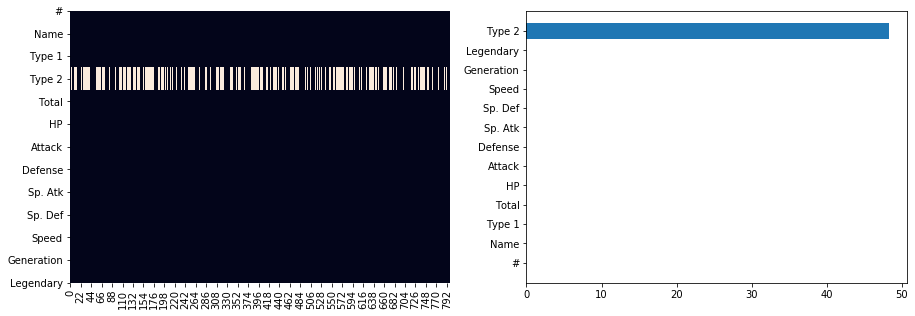

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)
axes = axes.flatten()
# checking missing data for each feature
sns.heatmap(data.isnull().T, cbar=False, ax = axes[0])
# percentage of missing values per feature
missing = pd.DataFrame({'column':data.columns ,'na_percent':data.isnull().sum()/len(data)*100})
missing.sort_values('na_percent',inplace=True)
axes[1].barh(missing['column'],width=missing['na_percent'])

**Task: Predict *Type 1* of a given pokemon since some pokemons don't have *Type 2***

Select relevant columns and top 4 Type1 classes with most samples.

In [5]:
data = data[data.columns.difference(['#', 'Name', 'Type 2'])]
data['Legendary']=data['Legendary'] * 1
data = data[data['Type 1'].isin(['Water', 'Normal', 'Grass', 'Bug'])] 
data.head()

,Attack,Defense,Generation,HP,Legendary,Sp. Atk,Sp. Def,Speed,Total,Type 1
0,49,49,1,45,0,65,65,45,318,Grass
1,62,63,1,60,0,80,80,60,405,Grass
2,82,83,1,80,0,100,100,80,525,Grass
3,100,123,1,80,0,122,120,80,625,Grass
9,48,65,1,44,0,50,64,43,314,Water


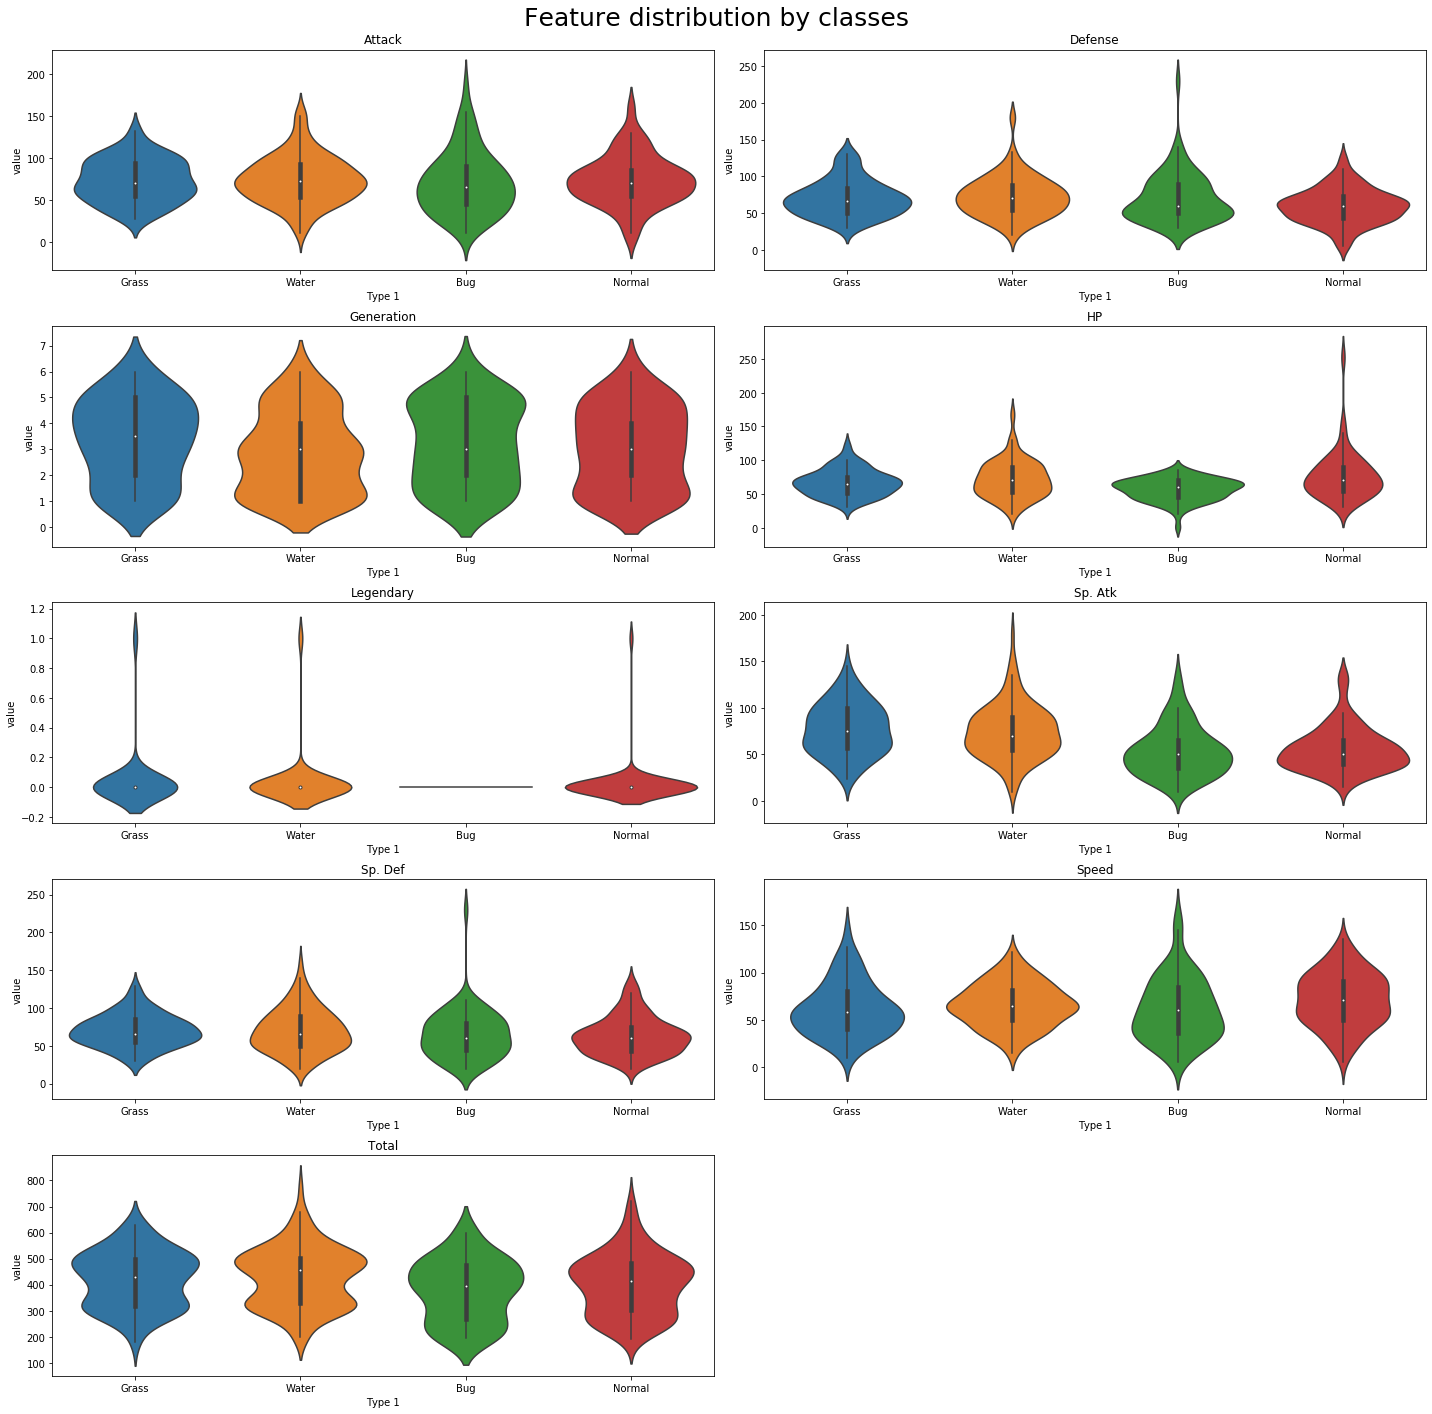

In [6]:
tmp = data.melt(id_vars=['Type 1'], value_vars=data.columns.difference(['Type 1']))
tmp = tmp.groupby('variable')
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20), sharey=False)
for (key, ax) in zip(tmp.groups.keys(), axes.flatten()):
    df = tmp.get_group(key)
    sns.violinplot(data=df, x='Type 1', y='value', ax = ax)
    ax.set_title(key)
axes.flat[-1].set_visible(False)
fig.suptitle('Feature distribution by classes', size = 25)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

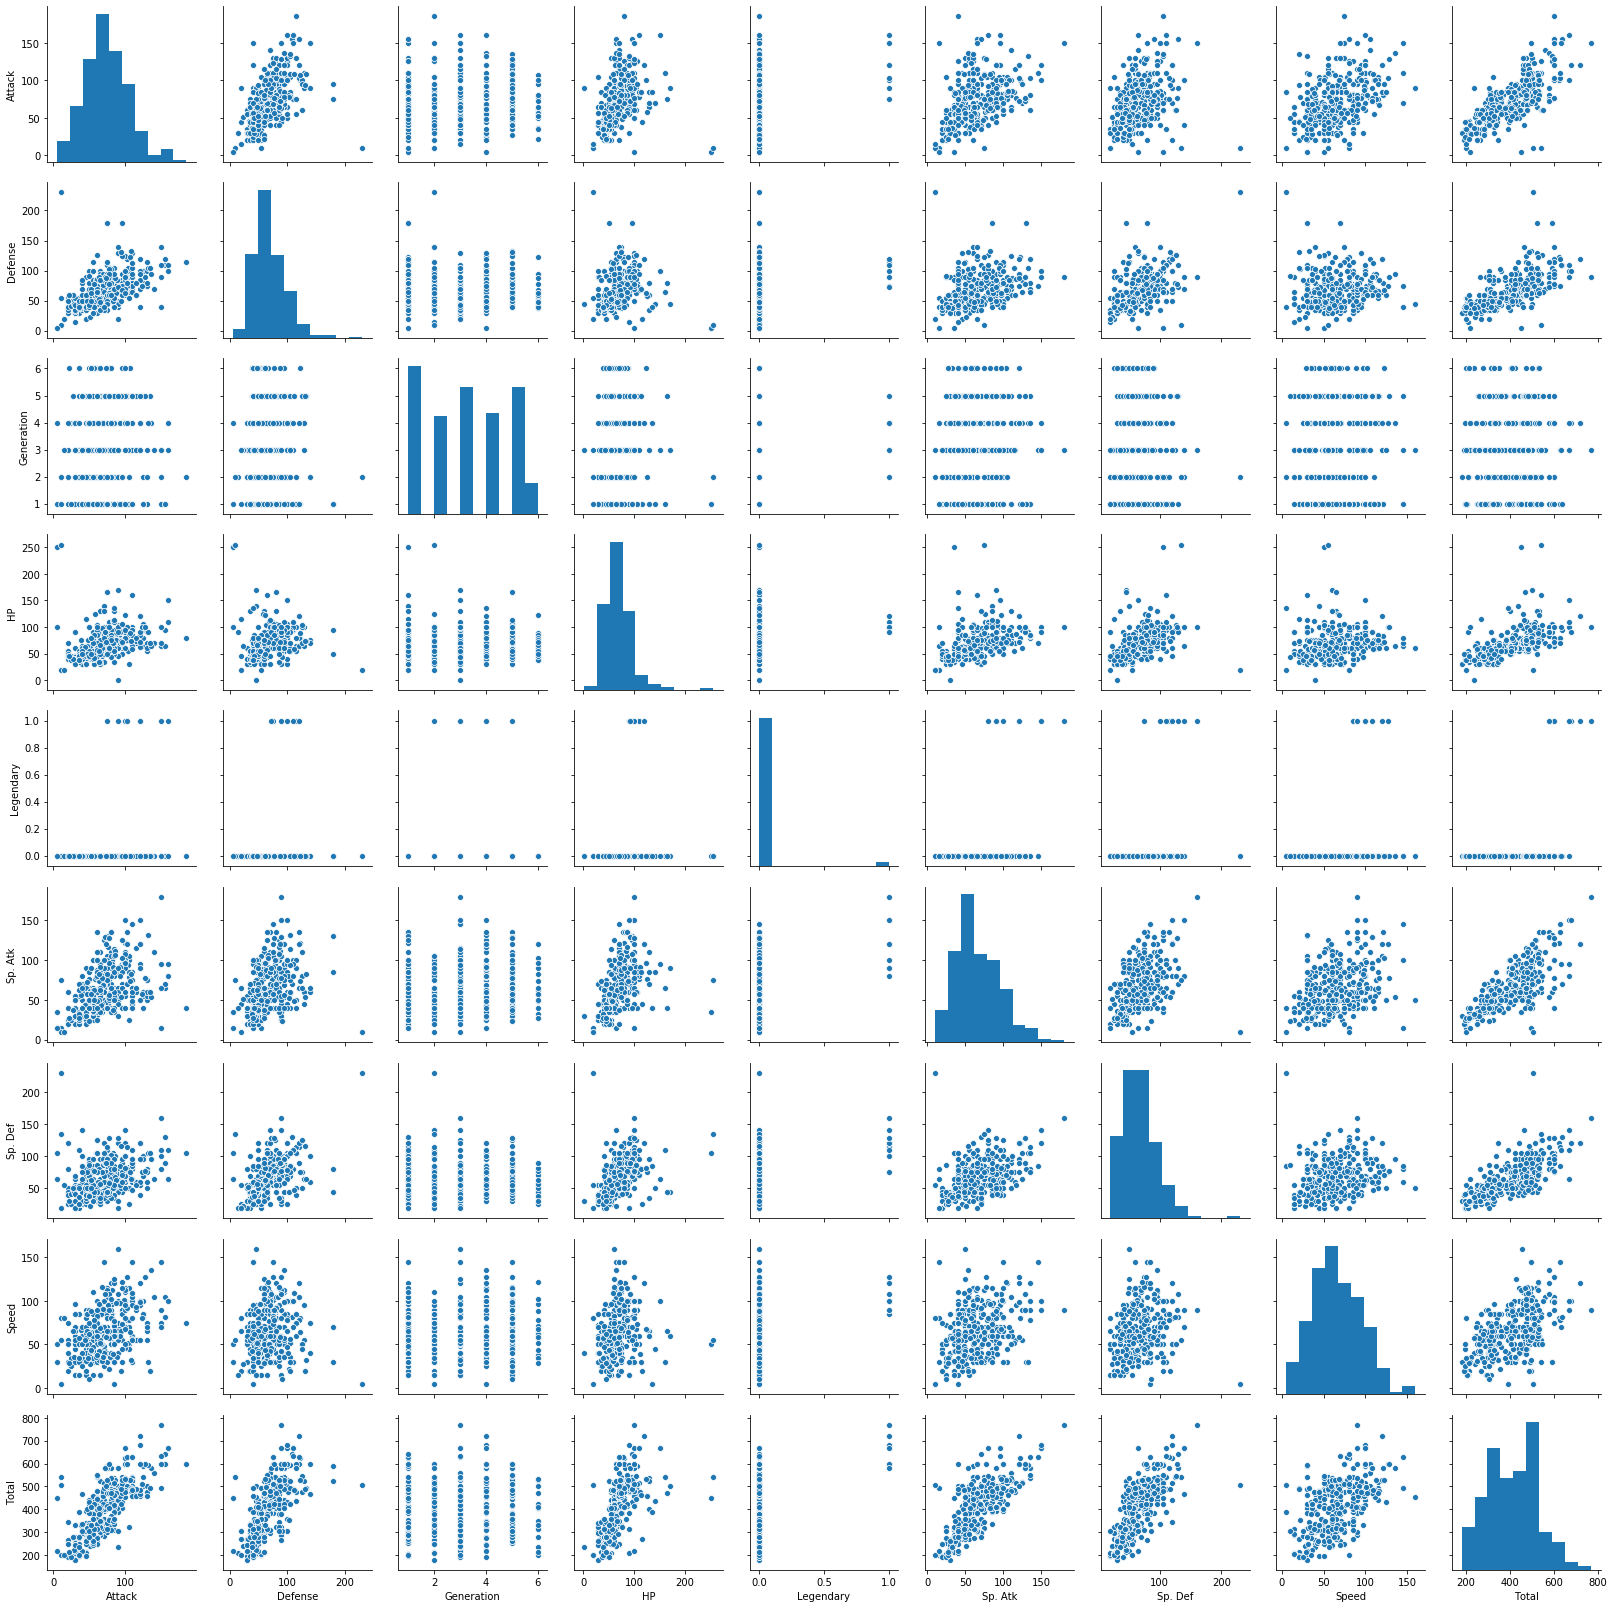

In [7]:
sns.pairplot(data[data.columns.difference(['Type 1'])])

### Dimensionality reduction

In [8]:
def array_to_df(arr, colname_prefix = 'gene', colnames = None, rownames = None):
    if colnames is None:
        colnames = [colname_prefix+str(i+1) for i in range(arr.shape[1])]
    if rownames is None:
        rownames = [i for i in range(arr.shape[0])]
        
    df=pd.DataFrame(data=arr[0:,0:],
                index=rownames,
                columns=colnames)
    return df

def run_rd(data, method, argument_dict = {}):
    rdm = partial(method, **argument_dict)()
    rd_pipe = Pipeline(steps = [('scaler', StandardScaler()), ('rd', rdm)])
    rd = array_to_df(rd_pipe.fit_transform(data[data.columns.difference(['Type 1'])]), colname_prefix = 'Dim')
    rd['Type1'] = data.reset_index()['Type 1']
    rd['Legendary'] = data.reset_index()['Legendary']
    return rd

In [9]:
pca = run_rd(data, method = PCA, argument_dict = {'n_components':2})
tsne = run_rd(data, method = TSNE, argument_dict = {'n_components':2})

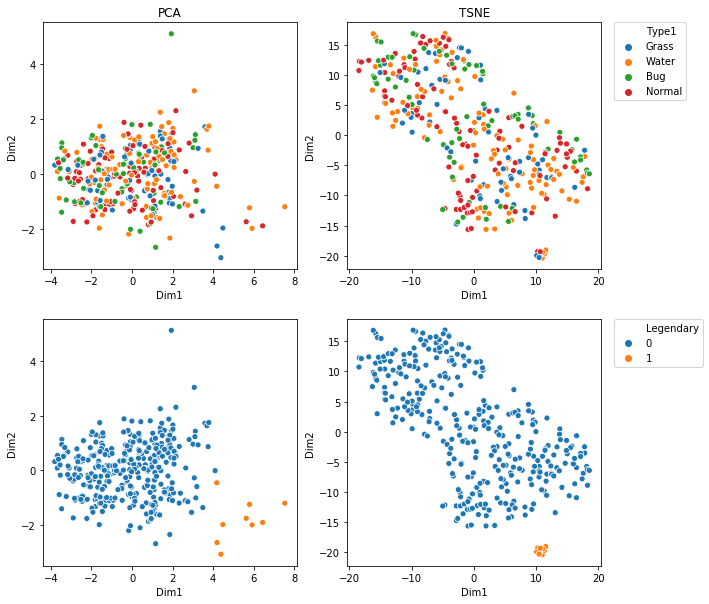

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.scatterplot(x="Dim1", y="Dim2", data=pca, hue='Type1', legend = False, ax= ax[0, 0])
sns.scatterplot(x="Dim1", y="Dim2", data=tsne, hue='Type1', ax= ax[0, 1])
ax[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[0, 0].set_title('PCA')
ax[0, 1].set_title('TSNE')
sns.scatterplot(x="Dim1", y="Dim2", data=pca, hue='Legendary', legend = False, ax= ax[1, 0])
sns.scatterplot(x="Dim1", y="Dim2", data=tsne, hue='Legendary', ax= ax[1, 1])
ax[1, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Use PCA and TSNE with default parameters, neither can separate pokemon type 1, TSNE can separate if a pokemon is Legendary or not quite accurately, which suggests that predicting if a pokemon is legendary is a significantly simpler task. In this case, I attempted a more challenging task of predicting pokemon type 1 instead. 

### Building classifiers

In [11]:
X_train, X_test, y_train, y_test = \
train_test_split(data[data.columns.difference(['Type 1'])], data['Type 1'], 
                 test_size=0.3, random_state=42, stratify = data['Type 1'])

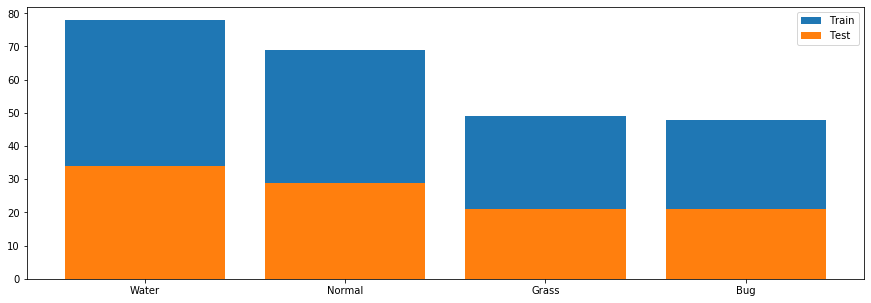

In [12]:
# NOT STACKED barchart, it's Overlapped/Superimposed Barchart
# checking label distributions are similar between train and test
tmp = pd.concat([pd.DataFrame(y_train.value_counts()), 
                 pd.DataFrame(y_test.value_counts())], 
                axis = 1, sort=False).reset_index()
tmp.columns = ['Type1', 'Train', 'Test']
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(tmp.Type1, tmp.Train, label = 'Train')
ax.bar(tmp.Type1, tmp.Test, label = 'Test')
ax.legend()

Let's use a over-sampling method called SMOTE (Synthetic Minority Over-sampling Technique) to mitigate the issue of imbalanced classes.

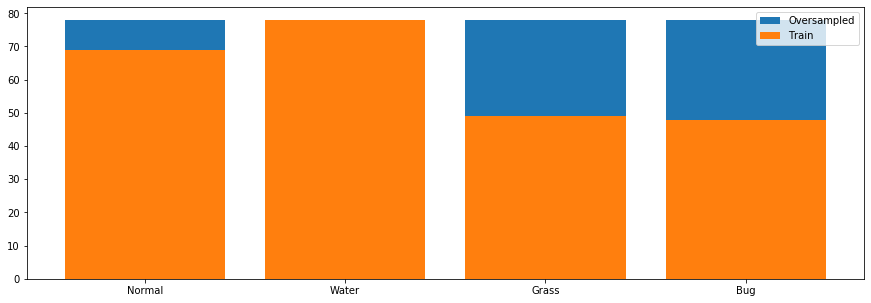

In [13]:
sm = SMOTE(sampling_strategy='not majority', random_state=42, k_neighbors=10)
X_res, y_res = sm.fit_resample(X_train, y_train)
tmp = pd.concat([pd.DataFrame(y_res.value_counts()), 
                 pd.DataFrame(y_train.value_counts())], 
                axis = 1, sort=False).reset_index()
tmp.columns = ['Type1', 'Train', 'Test']
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(tmp.Type1, tmp.Train, label = 'Oversampled')
ax.bar(tmp.Type1, tmp.Test, label = 'Train')
ax.legend()

In [14]:
def init_models(seed = 0):
    transformer = Pipeline(steps = [('scaler', StandardScaler())])
    LR = Pipeline(steps = [('preprocessing', transformer), 
                           ('classifier', LogisticRegression(class_weight = 'balanced', 
                                                             solver = 'lbfgs',
                                                             multi_class = 'multinomial',
                                                             n_jobs = -1))])
    GNB = Pipeline(steps = [('preprocessing', transformer), 
                            ('classifier', GaussianNB())])
    SVM = Pipeline(steps = [('preprocessing', transformer), 
                            ('classifier', SVC(class_weight='balanced', 
                                               probability=True,
                                               max_iter=-1, 
                                               kernel='linear',
                                               random_state=seed,
                                               decision_function_shape='ovo'))])
    KNN = Pipeline(steps = [('preprocessing', transformer),
                            ('classifier', KNeighborsClassifier(n_neighbors=10, 
                                                                weights='distance', 
                                                                algorithm = 'auto',
                                                                p = 2,  # Euclidean Distance
                                                                n_jobs=-1,))])
    MLP = Pipeline(steps = [('preprocessing', transformer), 
                            ('classifier', MLPClassifier(hidden_layer_sizes=(16, 8, 4), 
                                                         solver = 'adam',
                                                         learning_rate='adaptive',
                                                         max_iter=3000, 
                                                         random_state = seed, 
                                                         activation='relu'))])
    RF = Pipeline(steps = [('classifier', RandomForestClassifier(n_estimators=100, 
                                                                 n_jobs=-1, 
                                                                 class_weight = 'balanced',
                                                                 random_state=seed, 
                                                                 oob_score = False))])
    
    models = {}
    models['LR'] = {'cv': True, 'bagging': False, 'model': LR}
    models['GNB'] = {'cv': True, 'bagging': False, 'model': GNB}
    models['SVM'] = {'cv': True, 'bagging': False, 'model': SVM}
    models['KNN'] = {'cv': True, 'bagging': False, 'model': KNN}
    models['MLP'] = {'cv': True, 'bagging': False, 'model': MLP}
    models['RF'] = {'cv': True, 'bagging': True, 'model': RF}
    return models 

def make_score(metric, argument_dict = {}, needs_threshold = False, needs_proba = False):
    return {'callable': partial(metric, **argument_dict), 'needs_threshold': needs_threshold, 'needs_proba': needs_proba}

def build_models(models, X_train, y_train, cv, cv_random_state, cv_scoring, verbose = False):
    cv_scores = {}
    for model_name, model in models.items():
        if(model['cv']):
            if verbose: print('Cross-validation for', model_name)
            cv_scores[model_name] = cross_validate(model['model'], X_train, y_train, 
                                                   cv = StratifiedKFold(n_splits = cv, shuffle=True, 
                                                                        random_state=cv_random_state), 
                                                   scoring = cv_scoring, n_jobs=-1)
        if verbose: print('Fitting', model_name)
        models[model_name]['model'] = model['model'].fit(X_train, y_train)
    
    # collect cv scores     
    cv_rows = []
    for ok, ov in cv_scores.items():
        for ik, iv in ov.items(): 
            if('test_' in ik):
                row = {'model': ok, 'score_type': ik, 'mean': iv.mean(), 'std': iv.std()}
                cv_rows.append(row)
    cv_scores_df = pd.DataFrame(cv_rows) 
       
    return cv_scores_df, models 

def evaluate_models(models, X, y, eval_scoring, split):
    # collect evaluation scores
    eval_rows = []
    for model_name, model in models.items():
        for metric_name, metric in eval_scoring.items():
            if metric['needs_threshold']:
                if hasattr(model['model']['classifier'], 'decision_function'):
                # decision function
                    rows = [{'model': model_name, 'split': s, 'score_type': metric_name, \
                             'score': metric['callable'](yt, model['model'].decision_function(x))} \
                            for s, yt, x in zip([split], [y], [X])]
                    eval_rows.extend(rows)
                else:
                    raise ValueError('Estimator must have decision_function method')
            elif metric['needs_proba']:
                if hasattr(model['model']['classifier'], 'predict_proba'):
                # probability  
                    rows = [{'model': model_name, 'split': s, 'score_type': metric_name, \
                             'score': metric['callable'](yt, model['model'].predict_proba(x))} \
                            for s, yt, x in zip([split], [y], [X])]
                    eval_rows.extend(rows)
                else:
                    raise ValueError('Estimator must have predict_proba method')
            else:
                # discrete predictions
                rows = [{'model': model_name, 'split': s, 'score_type': metric_name, \
                         'score': metric['callable'](yt, model['model'].predict(x))} \
                        for s, yt, x in zip([split], [y], [X])]
                eval_rows.extend(rows)
    
    eval_scores_df = pd.DataFrame(eval_rows) 
    return eval_scores_df

In [15]:
models = init_models(seed = 0)

Candidate models:
- Logistic Regression (LR)
- Gaussian Naive Bayes (GNB)
- Support Vector Machine with linear kernel (SVM)
- K-Nearest Neighbors (KNN): 10 Nearest Neighbors, euclidean distance, let sklearn pick either brute-force search or a tree-based method, if tree-based, switch to brute-force search internally at leaf size of 30
- Multi-layer Perceptron (MLP): hidden layers = 16, 8, 4; relu activation function, adam optimizer with adaptive learning rate stating at 0.001, divided by 5 if training loss doesn't drops by at least 0.0001 after 10 consecutive epochs, cross-entropy loss
- Random Forest (RF): bags of 100 trees

Cross-Validation Performance Metrics Selection:
- Endgame: correctly distinguish a good classifier from a bad classifier 
- `balanced_accuracy`: average of recall [TP/(TP + FN)] obtained on each class, since we set `adjusted=True`, the range of the score from worst to best is [1/1-n_classes, 1], with with performance at random scoring 0, since we have 4 classes, the worst score is 1/(1-4) = -0.33
- weighted-f1: for each class, F1 is the weighted average of the precision and recall of that class F1 = 2 * (P * R) / (P + R), for multiclasses classification, the weighted-f1 is computed by calculating f1 for each label, and find their average, weighted by support (the number of true instances for each label).
- weighted-`roc_auc_score`: In the multiclass case, target scores must be probability estimates which sum to 1 so `roc_auc_score` can't be use with non-probabilistic classification methods (i.e., methods without `predict_proba` like `LinearSVC`), so to make `roc_auc_score` works for SVM, we will be using `SVC` with linear kernel instead of `LinearSVC` and set `probability=True` which uses cross-validation internally for `predict_proba`, weighted-`roc_auc_score` computed similar to weighted-f1.
- `matthews_corrcoef` (Matthews correlation coefficient or MCC): an underrated metric for binary classification with imbalanced classes, correlation coefficient ranges from -1 to 1 with -1 means perfect negative correlation, 0 means no correlation and 1 means perfect positive correlation, we want y_true and y_predict to have perfect positive correlation so 1 is the best score (FP = FN = 0), and -1 is the worst score (TP = TN = 0). MCC can be extend for multiclass problem.
- Also see [Why Cohen’s Kappa should be avoided as performance measure in classification.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916) 
- Notice: RF has Out of Bag error which can be used as an estimation of the generalization error without having to rely on a separate validation set or cross-validation, however, to make comparison among candidate models more convenience, I chose to use cross-validation instead of `oob_score`. 

In [16]:
cv_scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score, adjusted=True), 
              'f1': make_scorer(fbeta_score, beta = 1, average = 'weighted'), 
              'roc_auc': make_scorer(roc_auc_score, average = 'macro', 
                                     needs_proba=True, multi_class = 'ovr'),
              'mcc': make_scorer(matthews_corrcoef)}
cv_scores_df, models = build_models(models, X_res, y_res, cv = 5, cv_random_state = 42, 
                                    cv_scoring = cv_scoring, verbose = True)

Cross-validation for LR
Fitting LR
Cross-validation for GNB
Fitting GNB
Cross-validation for SVM
Fitting SVM
Cross-validation for KNN
Fitting KNN
Cross-validation for MLP
Fitting MLP
Cross-validation for RF
Fitting RF


Text(0.5, 0.98, 'Cross-validation scores')

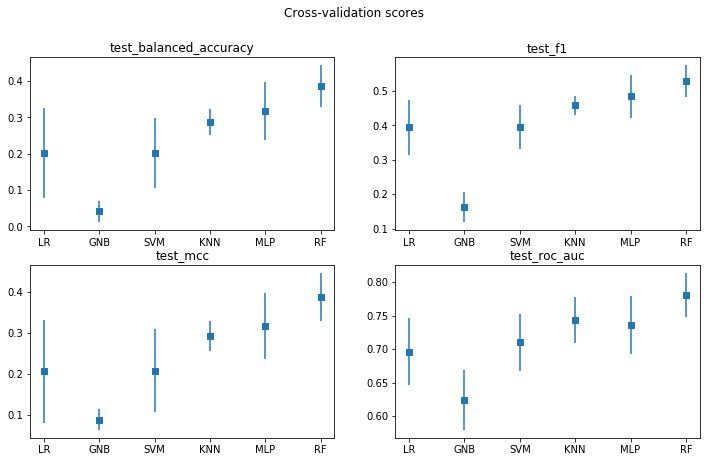

In [17]:
tmp = cv_scores_df.groupby('score_type')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharey=False)
for (key, ax) in zip(tmp.groups.keys(), axes.flatten()):
    df = tmp.get_group(key)
    ax.errorbar(df['model'], y = df['mean'], yerr = df['std'], marker='s', fmt='.')
    ax.set_title(key)
fig.suptitle('Cross-validation scores')

Based on 5-fold cross-validation, KNN, MLP and RF are the top 3 models in all 4 performance metrics, however, their performance on average (i.e., across classes) are just slightly better than random guesses. 

In [18]:
eval_scoring = {'balanced_accuracy': make_score(balanced_accuracy_score, {'adjusted':True}),
                'f1': make_score(fbeta_score, {'beta':1, 'average':'weighted'}),
                'roc_auc': make_score(roc_auc_score, {'average':'macro', 'multi_class':'ovr'}, needs_proba = True),
                'mcc': make_score(matthews_corrcoef)}
eval_scores_df = evaluate_models(models, X_train, y_train, eval_scoring, split = 'train')

Checking how well each model fit the training set

Text(0.5, 0.98, 'Train scores')

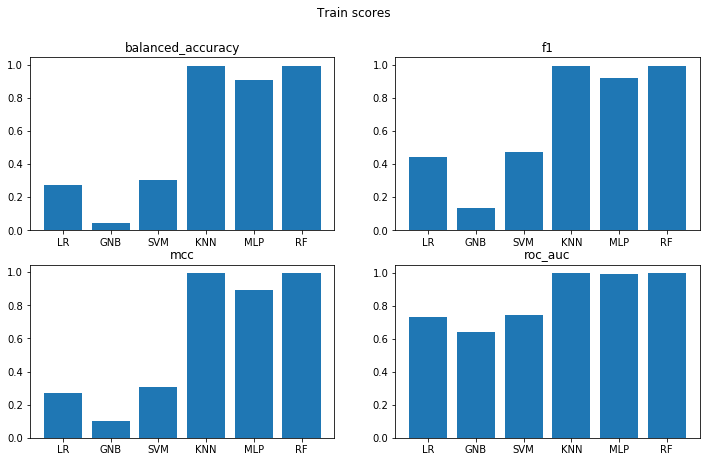

In [19]:
tmp = eval_scores_df.groupby('score_type')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharey=False)
for (key, ax) in zip(tmp.groups.keys(), axes.flatten()):
    df = tmp.get_group(key)
    ax.bar(df['model'], df['score'])
    ax.set_title(key)
fig.suptitle('Train scores')

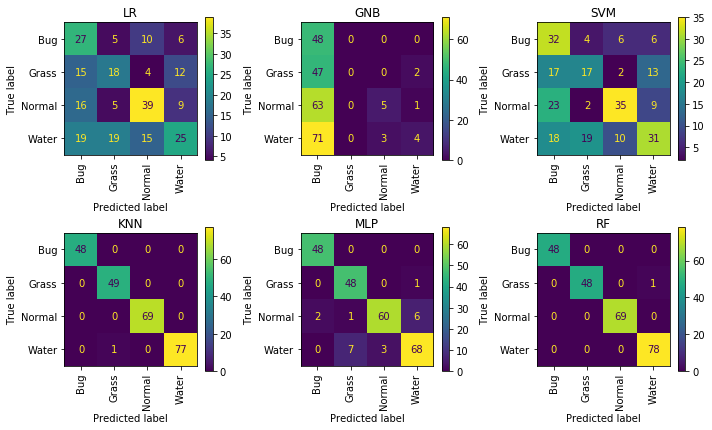

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharey=False)
for (model_name, model), ax in zip(models.items(), axes.flatten()):
    plot_confusion_matrix(model['model'], X_train, y_train, ax=ax, normalize=None, 
                         xticks_rotation = 'vertical', values_format = '.0f')
    ax.set_title(model_name)
fig.tight_layout()

- LR, GNB and SVM underfit the training data while KNN, MLP and RF can fit the training data almost perfectly but they performed poorly during cross-validation which indicates overfitting. 
- Can use boosting to improve performance of LR, GNB or SVM, but I decide to use cross-validation to tune parameters of the models that I suspect are overfitting to combat the issue.  

### Hyper-parameters tunning

In [21]:
def tune_params(model, X, y, param_dict, scoring, cv):
    grid_search = GridSearchCV(model, param_grid=param_dict, scoring=scoring,
                           cv=cv, error_score=0, n_jobs=-1, refit=False)
    grid_search.fit(X, y)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cols = cv_results.filter(regex='^rank_').columns
    # row that have min total rank across all metrics 
    best_params = cv_results['params'][cv_results[cols].sum(axis = 1).idxmin()]
    return best_params

In [22]:
KNN_param_dict = dict(classifier__n_neighbors=[3, 5, 10],
                      classifier__weights=['uniform', 'distance'],
                      classifier__p=[1, 2])
MLP_param_dict = dict(classifier__activation=['tanh', 'relu'],
                      classifier__solver=['lbfgs', 'adam'],
                      classifier__learning_rate=['invscaling', 'adaptive'],
                      classifier__early_stopping=[True, False],
                      classifier__alpha=[0.01, 1],
                      classifier__learning_rate_init=[0.001, 0.01, 0.1])
RF_param_dict = dict(classifier__n_estimators=[50, 100, 200],
                     classifier__ccp_alpha=[0.01, 0.05, 0.1, 0.5]) #tree pruning, combat overfit

models = init_models(seed = 0)
candiate_models = {k: v for k, v in models.items() if k in ['KNN', 'MLP', 'RF']}
for v, p in zip(candiate_models.values(), [KNN_param_dict, MLP_param_dict, RF_param_dict]):
    v['best_params'] = tune_params(v['model'], X_res, y_res, p, cv_scoring, cv=3)

In [23]:
final_models = {}
for (ok, ov), m in zip(candiate_models.items(), [KNeighborsClassifier, MLPClassifier, RandomForestClassifier]):
    best_params = {k.replace('classifier__', ''):v for k, v in ov['best_params'].items()}
    all_params = ov['model']['classifier'].get_params()
    all_params = {k:best_params[k] if k in best_params.keys() else v for k, v in all_params.items()}
    # same as the classifer defined above with target paramaters replaced with best value from cross-validation
    model = partial(m, **all_params) 
    if ok in ['KNN', 'MLP']:
        # use dict of dict so we can reuse evaluate_models()
        final_models[ok] = {'model':Pipeline(steps = [('preprocessing', StandardScaler()), 
                                                      ('classifier', model())])}
    else:
        final_models[ok] = {'model':Pipeline(steps = [('classifier', model())])}
    
    # fit model    
    final_models[ok]['model'] = final_models[ok]['model'].fit(X_res, y_res)

Checking how well each model fit the test set

Text(0.5, 0.98, 'Test scores')

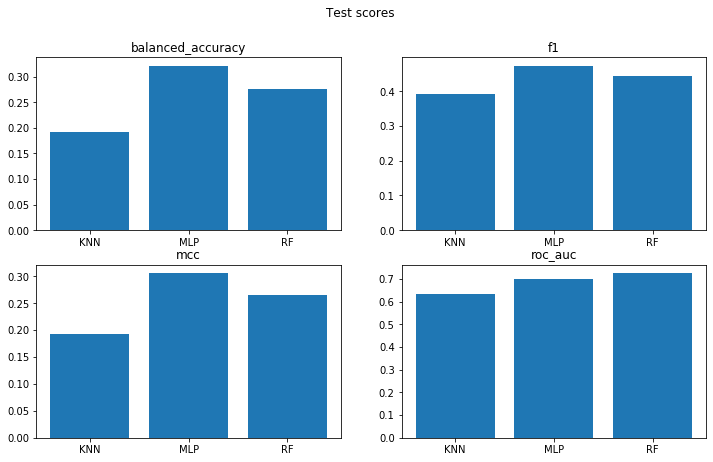

In [24]:
eval_scores_df = evaluate_models(final_models, X_test, y_test, eval_scoring, split = 'test')
tmp = eval_scores_df.groupby('score_type')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharey=False)
for (key, ax) in zip(tmp.groups.keys(), axes.flatten()):
    df = tmp.get_group(key)
    ax.bar(df['model'], df['score'])
    ax.set_title(key)
fig.suptitle('Test scores')

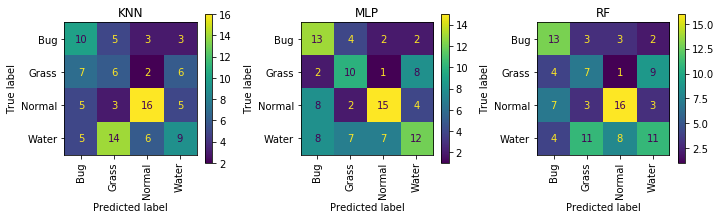

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=False)
for (model_name, model), ax in zip(final_models.items(), axes.flatten()):
    plot_confusion_matrix(model['model'], X_test, y_test, ax=ax, normalize=None, 
                         xticks_rotation = 'vertical', values_format = '.0f')
    ax.set_title(model_name)
fig.tight_layout()

### Save models 

In [26]:
os.makedirs('models', exist_ok=True)
for k, v in final_models.items():
    model_name = k + '.pkl'
    with open(os.path.join('models', model_name), 'wb') as file:
        pickle.dump(v['model'], file)